In [1]:
import numpy as np    # Linear algebra
import pandas as pd    # Data processing, csv file read/write
import seaborn as sns
import matplotlib.pyplot as plt    # For plots
from mpltools import special    # For Hinton diagram   

# For feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier

# Standardizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Splitting data into test and train datasets
from sklearn.model_selection import train_test_split

# Cross validation
from sklearn.model_selection import cross_val_score

# Classifiers
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Used for normaltest
import scipy.stats as stats

# For scoring
from sklearn import metrics

# Ignores minor warnings 
import warnings
warnings.filterwarnings('ignore')

# For displaying graphs
%matplotlib inline

In [2]:
# Clean data by removing 0 values

def dataPreparation(datasetCopy):
    # Replacing 0 values in Insulin with mean
    datasetInsulin = datasetCopy['Insulin']
    datasetInsulin[datasetInsulin == 0] = np.nan
    datasetCopy['Insulin'] = datasetInsulin
    insulinMean = datasetCopy['Insulin'].mean()
    datasetCopy['Insulin'].fillna(insulinMean, inplace=True) 
    
    # Replacing 0 values in SkinThickness with mean
    datasetSkinThickness = datasetCopy['SkinThickness']
    datasetSkinThickness[datasetSkinThickness == 0] = np.nan
    datasetCopy['SkinThickness'] = datasetSkinThickness
    skinThicknessMean = datasetCopy['SkinThickness'].mean()
    datasetCopy['SkinThickness'].fillna(skinThicknessMean, inplace=True) 
    
    # Replacing 0 values in BloodPressure with mean
    datasetBloodPressure = datasetCopy['BloodPressure']
    datasetBloodPressure[datasetBloodPressure == 0] = np.nan
    datasetCopy['BloodPressure'] = datasetBloodPressure
    bloodPressureMean = datasetCopy['BloodPressure'].mean()
    datasetCopy['BloodPressure'].fillna(bloodPressureMean, inplace=True) 

    # Replacing 0 values in Glucose with mean
    datasetGlucose = datasetCopy['Glucose']
    datasetGlucose[datasetGlucose == 0] = np.nan
    datasetCopy['Glucose'] = datasetGlucose
    glucoseMean = datasetCopy['Glucose'].mean()
    datasetCopy['Glucose'].fillna(glucoseMean, inplace=True) 

    # Replacing 0 values in BMI with mean
    datasetBMI = datasetCopy['BMI']
    datasetBMI[datasetBMI == 0] = np.nan
    datasetCopy['BMI'] = datasetBMI
    BMIMean = datasetCopy['BMI'].mean()
    datasetCopy['BMI'].fillna(BMIMean, inplace=True) 
    
    return datasetCopy

In [3]:
# Stratified split, based on the outcome, on the dataset
# returned sets contain all features

def stratifiedSplitComplete(datasetCopy):
    datasetTrain, datasetTest = train_test_split(datasetCopy, test_size=0.20, random_state=66, stratify=datasetCopy['Outcome'])
    
    trainFeatures = datasetTrain[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Insulin', 'SkinThickness']]
    testFeatures = datasetTest[['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Insulin', 'SkinThickness']]
    trainOutcome = datasetTrain['Outcome']
    testOutcome = datasetTest['Outcome']
    
    return trainFeatures, trainOutcome, testFeatures, testOutcome  

In [4]:
# Stratified split, based on the outcome, on the dataset
# returned sets contain selected features (glucose, BMI and age)

def stratifiedSplit(datasetCopy):
    datasetTrain, datasetTest = train_test_split(datasetCopy, test_size=0.20, random_state=66, stratify=datasetCopy['Outcome'])
    
    trainFeatures = datasetTrain[['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
    testFeatures = datasetTest[['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
    trainOutcome = datasetTrain['Outcome']
    testOutcome = datasetTest['Outcome']
    
    return trainFeatures, trainOutcome, testFeatures, testOutcome  

In [5]:
# Scale data using RobustScaler

def scalerRobust(datasetCopy):
    datasetFeaturesRobust = RobustScaler().fit_transform(datasetCopy[['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']])
    dataframeRobust = pd.DataFrame(datasetFeaturesRobust, columns=['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age'])

    dataframeRobust['Outcome'] = datasetCopy['Outcome']
    
    trainFeaturesRobust, trainOutcomeRobust, testFeaturesRobust, testOutcomeRobust = stratifiedSplit(dataframeRobust)

    return trainFeaturesRobust, trainOutcomeRobust, testFeaturesRobust, testOutcomeRobust  

In [6]:
# Scale data using MinMaxScaler

def scalerMinMax(datasetCopy):
    datasetFeaturesMinMax = MinMaxScaler().fit_transform(datasetCopy[['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']])
    dataframeMinMax = pd.DataFrame(datasetFeaturesMinMax, columns=['Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age'])

    dataframeMinMax['Outcome'] = datasetCopy['Outcome']

    trainFeaturesMinMax, trainOutcomeMinMax, testFeaturesMinMax, testOutcomeMinMax = stratifiedSplit(dataframeMinMax)
    
    return trainFeaturesMinMax, trainOutcomeMinMax, testFeaturesMinMax, testOutcomeMinMax  

In [7]:
# Compare the results from the two differently scaled datasets
# using 5-fold cross validation

def scalerComparison(modelLabels, models, datasetCopy):
    scoreRobust = []    # score results of classifiers on RobustScaler-scaled dataset
    scoreMinMax = []    # score results of classifiers on MinMaxScaler-scaled dataset
    for i in models:
        model = i
        
        # Test model using RobustScaler dataset
        trainFeaturesRobust, trainOutcomeRobust, testFeaturesRobust, testOutcomeRobust = scalerRobust(datasetCopy)
        cv_result = cross_val_score(model, trainFeaturesRobust, trainOutcomeRobust, cv = 5, scoring = "accuracy")
        scoreRobust.append(cv_result.mean())
        
        # Test model using MinMaxScaler dataset
        trainFeaturesMinMax, trainOutcomeMinMax, testFeaturesMinMax, testOutcomeMinMax = scalerMinMax(datasetCopy)
        cv_result = cross_val_score(model, trainFeaturesMinMax, trainOutcomeMinMax, cv = 5, scoring = "accuracy")
        scoreMinMax.append(cv_result.mean())
        
    scalerComparison = pd.DataFrame(scoreRobust, index=modelLabels)
    scalerComparison.columns = ['Robust Scaler']
    scalerComparison['MinMax Scaler'] = scoreMinMax
    
    return scalerComparison

In [8]:
# Test classifiers using accuracy scoring, cross validation, confusion matrix, sensitivity, and specificity

def classifierResults(modelLabels, models, datasetCopy):
    trainFeaturesRobust, trainOutcomeRobust, testFeaturesRobust, testOutcomeRobust = scalerRobust(datasetCopy)
    for i in models:
        model = i
        print('Results for ', i)
        model.fit(trainFeaturesRobust, trainOutcomeRobust)
        
        cv_result = cross_val_score(model, trainFeaturesRobust, trainOutcomeRobust, cv = 5, scoring = "accuracy")
        print('Mean of result after 5 fold cross validation:', cv_result.mean())
        
        prediction=model.predict(testFeaturesRobust)
        print('The accuracy on the test set:',metrics.accuracy_score(testOutcomeRobust, prediction))

        confusionMatrix = metrics.confusion_matrix(testOutcomeRobust, prediction)
        TN, FP, FN, TP = confusionMatrix.ravel()

        print("Sensitivity: %.4f" % (TP / float(TP + FN)))
        print("Specificity: %.4f" % (TN / float(TN + FP)))
        
        plt.title('Confusion matrix')
        sns.heatmap(confusionMatrix, annot=True, cmap="YlGn")
        plt.xlabel('Predicted classes')
        plt.ylabel('True Classes')
        plt.show()

In [9]:
# Import and read data
datasetComplete = pd.read_csv("diabetes.csv")

In [10]:
# Display first few rows
datasetComplete.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [11]:
# Get information about columns (non-null and null data)
# datasetComplete.isnull().values.any() could also be used to check for the presence of an null values
# But datasetComplete.info() gives more information about the dataset

datasetComplete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.0 KB


In [12]:
# To describe the data present in each column (mean, standard deviation minimum and maximum among others
datasetComplete.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


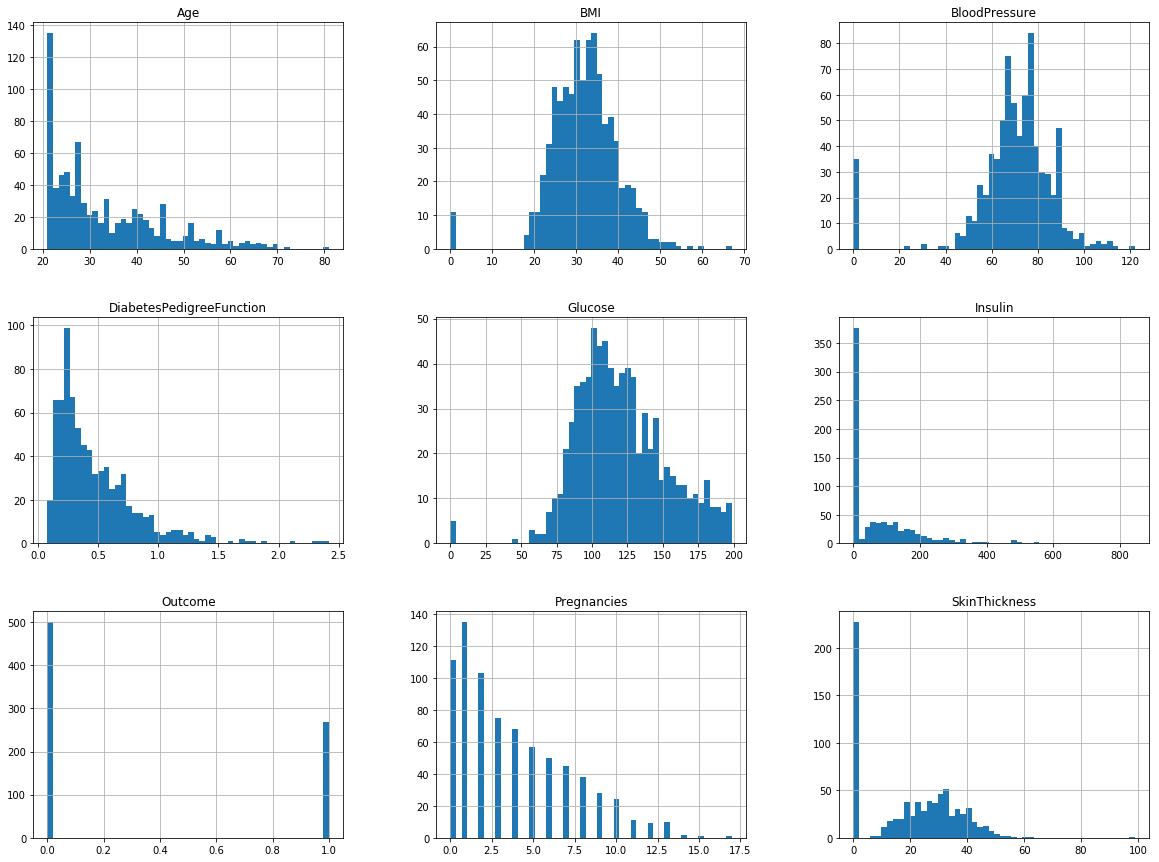

In [13]:
# Visualize entire data (uncleaned)
datasetComplete.hist(bins=50, figsize=(20,15))
plt.show()

In [14]:
# Create a copy of dataset
datasetCopy = datasetComplete.copy()

# Clean dataset
datasetCopy = dataPreparation(datasetCopy);

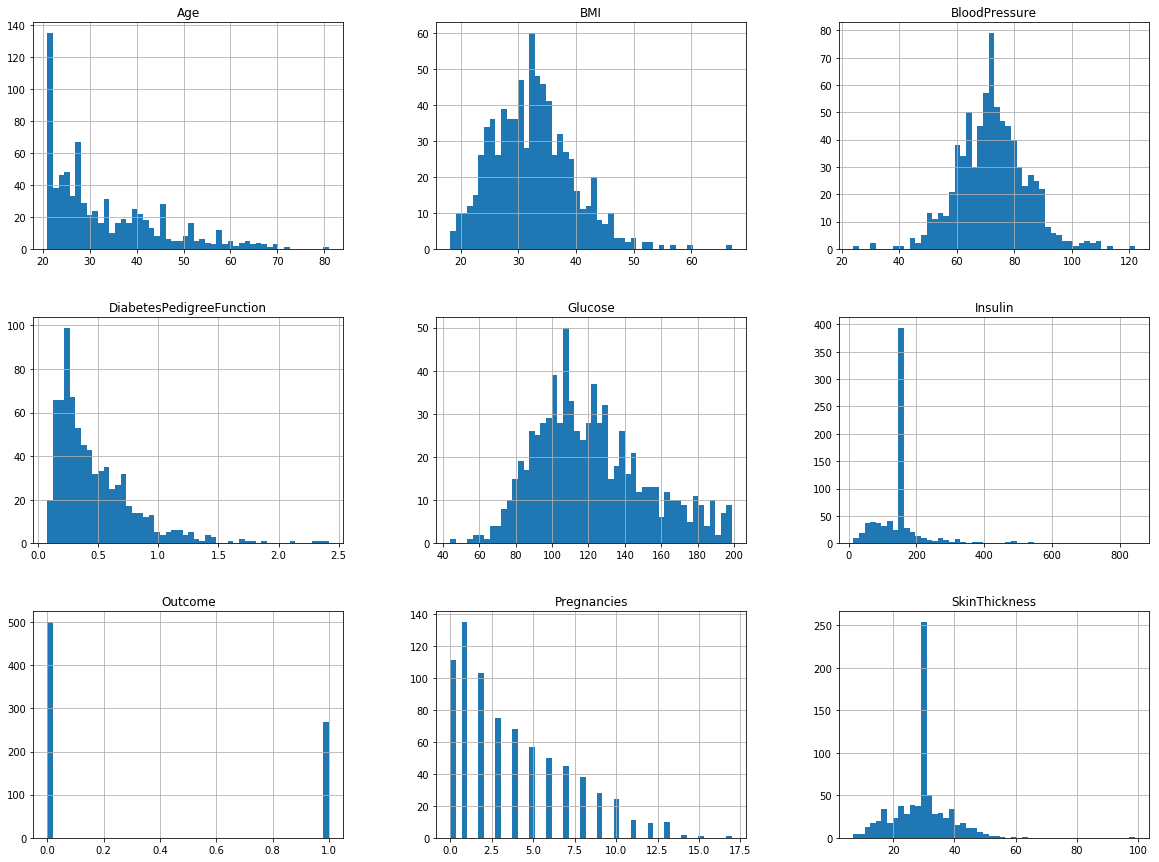

In [15]:
# Visualize entire data, post data cleaning
datasetCopy.hist(bins=50, figsize=(20,15))
plt.show()

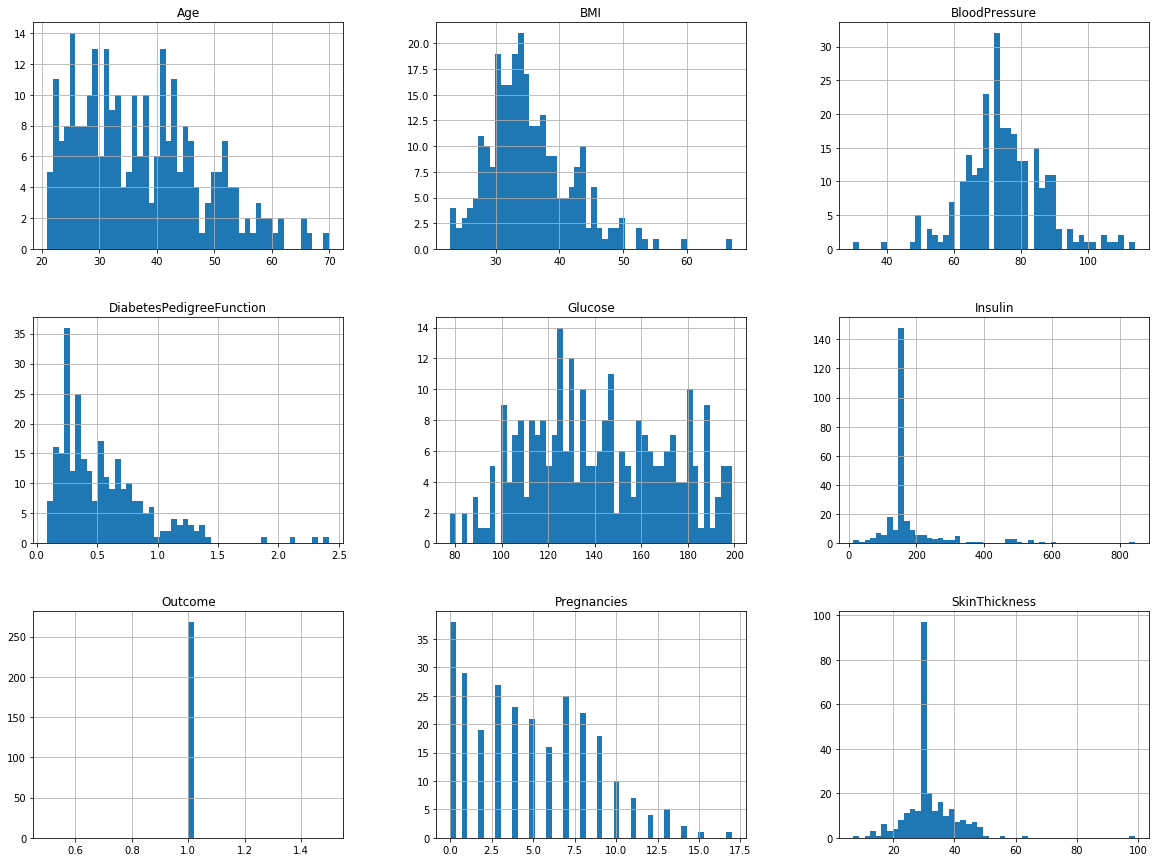

In [16]:
# Visualize cleaned data only where outcome = 1 (which is that the individual has diabetes)
diabetesPositive = datasetCopy[datasetCopy["Outcome"] == 1]
diabetesPositive.hist(bins=50, figsize=(20,15))
plt.show()

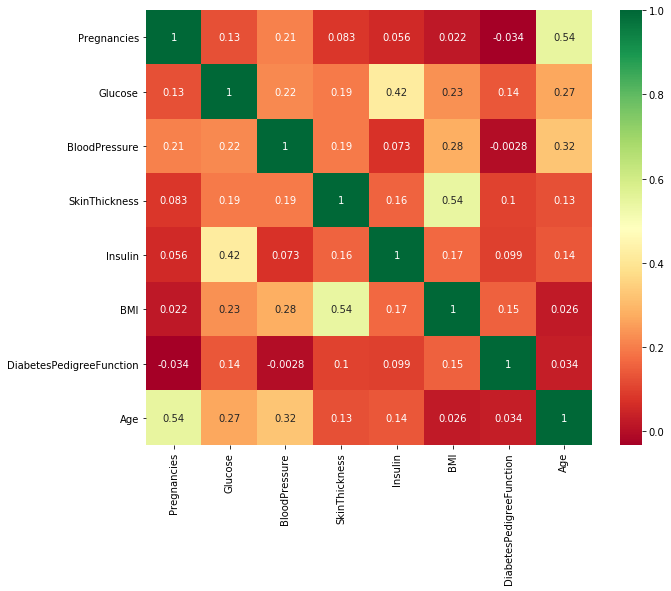

In [17]:
# One method of checking correlation between two factors
# Coulmns with high correlation may be eliminated as the inforation they provide
# can be dervied from their correlated column.
# All columns highly uncorrelated here, so can't remove any. 
sns.heatmap(datasetCopy[datasetCopy.columns[:8]].corr(),annot=True,cmap='RdYlGn')
#special.hinton(datasetCopy[datasetCopy.columns[:8]].corr())

# To change size of the output
fig=plt.gcf()    # Get reference to the current figure
fig.set_size_inches(10,8)    # Change size of figure

plt.show()    # SHow figure

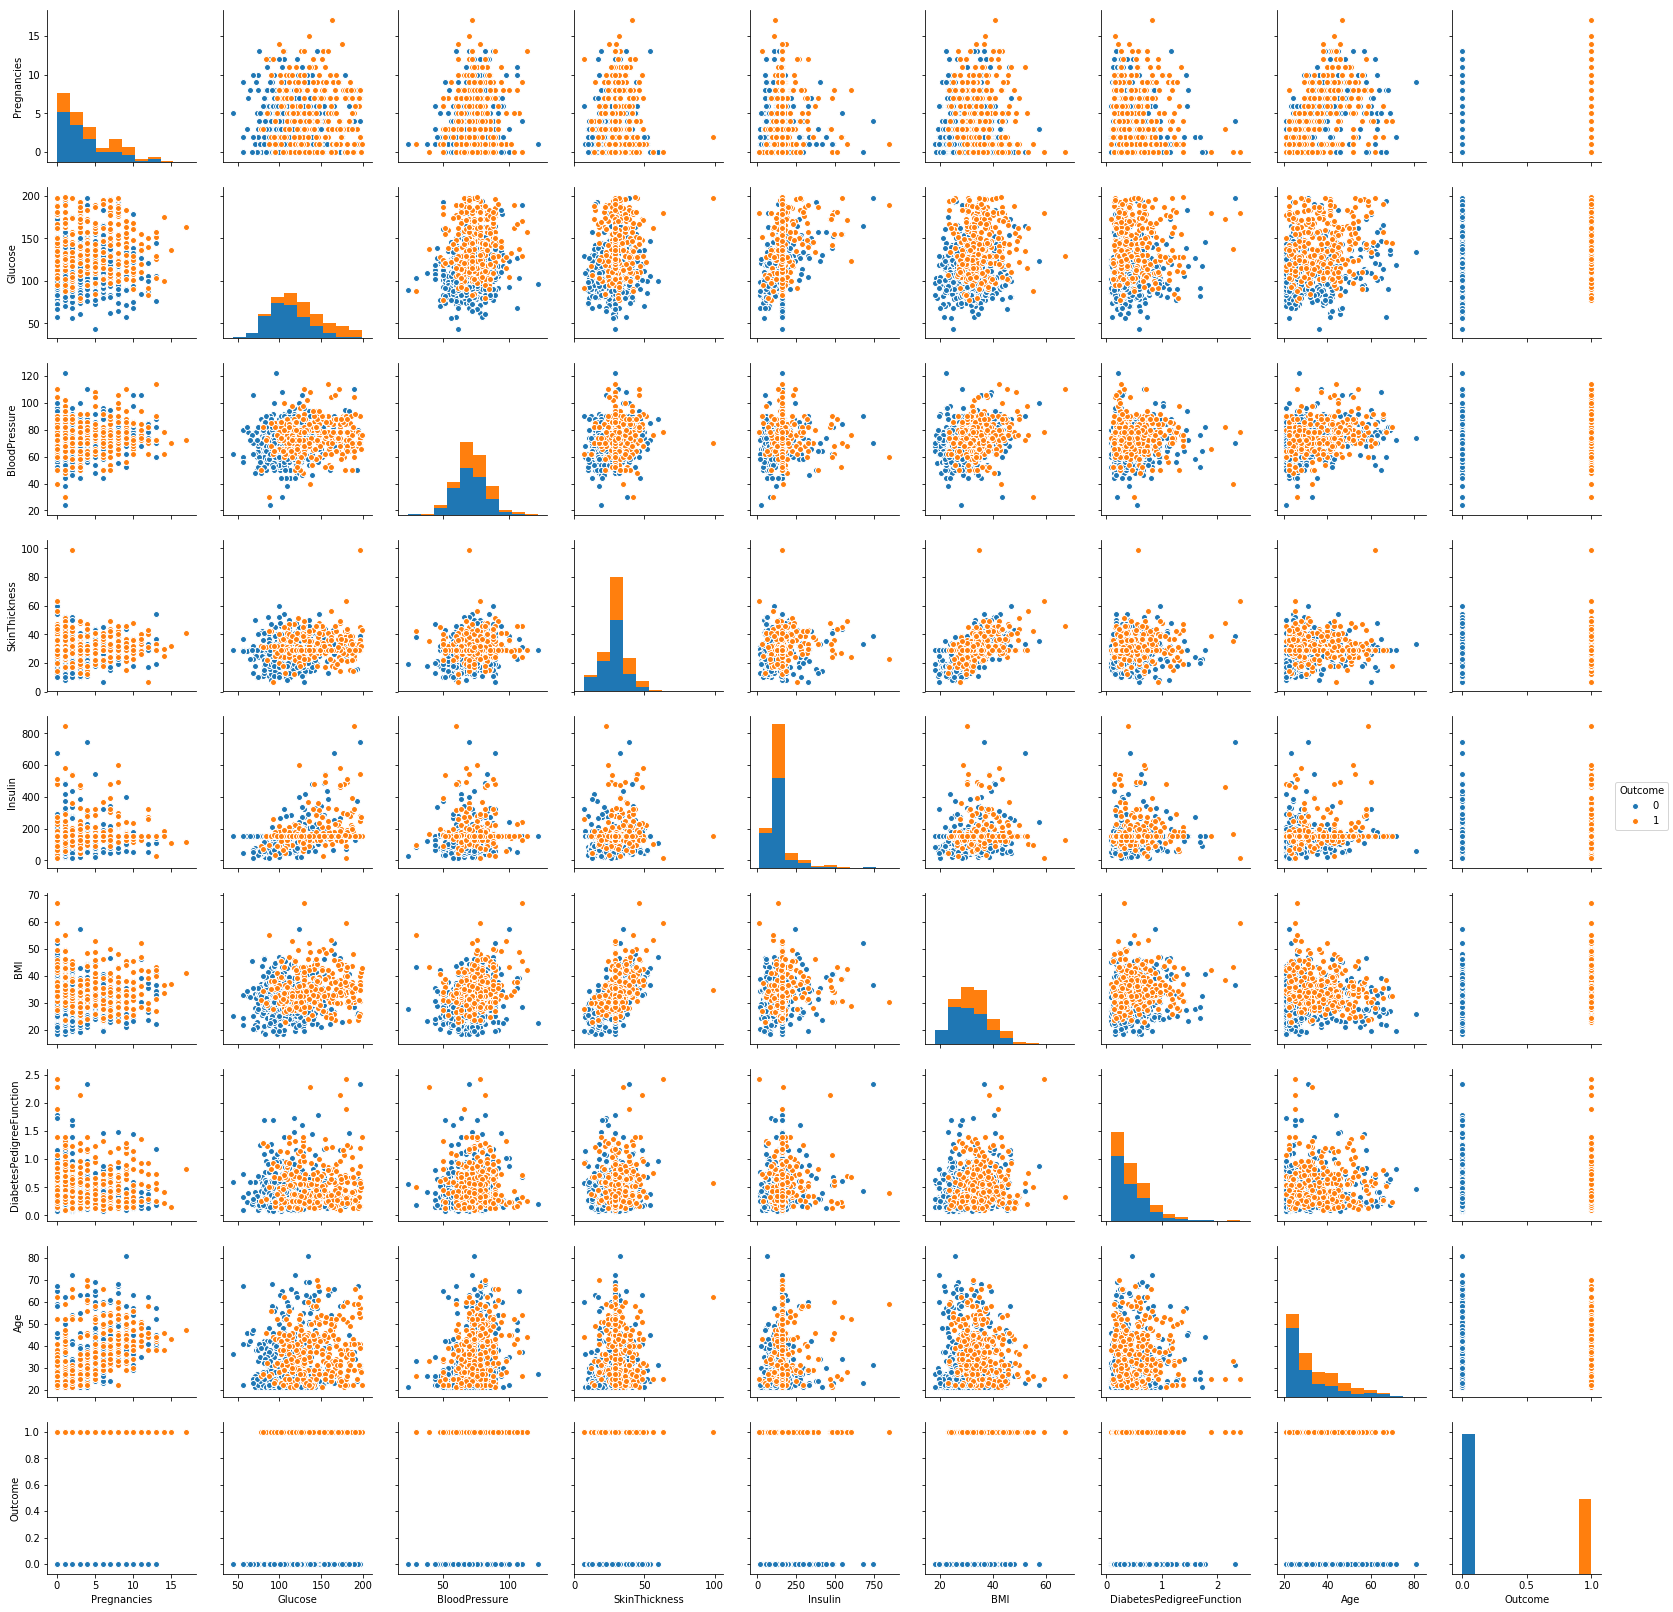

In [18]:
# To see if any two attribute pairs can help separate outcome
sns.pairplot(data=datasetCopy,hue='Outcome')
plt.show()

In [19]:
# Split data, so as to analyse only training data
trainFeatures, trainOutcome, testFeatures, testOutcome = stratifiedSplitComplete(datasetCopy)

In [34]:
Labels = ['Pregnancies', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Insulin', 'SkinThickness']

def extract_pruned_features(feature_importances, min_score=0.05):
    column_slice = feature_importances[feature_importances['weights'] > min_score]
    return column_slice

def feature_extractor(model, min_score):
    model.fit()


# Feature selection with RandomForestClassifier
model= RandomForestClassifier(random_state=1)
model.fit(trainFeatures, trainOutcome)
featuresDataFrame = pd.DataFrame(model.feature_importances_, index=Labels)
featuresDataFrame.columns = ['Random Forest']


# Feature selection with RandomForestClassifier
model= ExtraTreesClassifier(random_state=1)
model.fit(trainFeatures, trainOutcome)
featuresDataFrame['Extra Trees'] = model.feature_importances_

# Feature selection with XGBlassifier
model = XGBClassifier(n_estimators = 500, random_state = 1)
model.fit(trainFeatures, trainOutcome)
featuresDataFrame['XGBoost'] = model.feature_importances_
pruned = featuresDataFrame[featuresDataFrame['XGBoost'] > 0.1]
pruned

#featuresDataFrame

,Random Forest,Extra Trees,XGBoost
Glucose,0.261137,0.240184,0.168375
BloodPressure,0.080372,0.095686,0.113836
BMI,0.196504,0.134272,0.185944
DiabetesPedigreeFunction,0.109848,0.118452,0.196559
Age,0.129355,0.115313,0.102489


In [ ]:
# Checking p-values, which is one way of checking if our dataset follows a normal distribution
# low p-values imply does not follow normal distribution
stats.normaltest(trainFeatures)

In [ ]:
# As p-values low we select RobustScaler and MinMaxScaler and scale data 
trainFeaturesRobust, trainOutcomeRobust, testFeaturesRobust, testOutcomeRobust = scalerRobust(datasetCopy)
trainFeaturesMinMax, trainOutcomeMinMax, testFeaturesMinMax, testOutcomeMinMax = scalerMinMax(datasetCopy)

In [ ]:
trainFeaturesRobust.describe()

In [ ]:
testFeaturesRobust.describe()

In [ ]:
# Classifiers being used
modelLabels = ['Linear Svm','Radial Svm', 
              'Gaussian Naive Bayes', 'Multi-layer Perceptron', 
               'GradientBoosting']
models = [svm.SVC(kernel='linear', class_weight = 'balanced'), svm.SVC(kernel='rbf', class_weight = 'balanced'),
          GaussianNB(), MLPClassifier(random_state=66), 
          GradientBoostingClassifier(random_state=66)]

In [ ]:
# Compare the results from the two different scalers
comparison = scalerComparison(modelLabels, models, datasetCopy)
comparison

In [ ]:
# Test classifiers
classifierResults(modelLabels, models, datasetCopy)

In [ ]:
# Using voting classifier to ensemble the three classifiers with highest cross validation scores
radial_svm=svm.SVC(kernel='rbf', probability=True, class_weight = 'balanced')
gnb = GaussianNB()
mlp = MLPClassifier(random_state = 66)

ensemble = VotingClassifier(estimators=[('SVM RBF', radial_svm), ('GNB', gnb)], 
                       voting='soft').fit(trainFeaturesRobust, trainOutcomeRobust)
prediction = ensemble.predict(testFeaturesRobust)
print('The accuracy for the ensemble is:', ensemble.score(testFeaturesRobust, testOutcomeRobust))

confusionMatrix = metrics.confusion_matrix(testOutcomeRobust, prediction)
TN, FP, FN, TP = confusionMatrix.ravel()

print("Sensitivity: %.4f" % (TP / float(TP + FN)))
print("Specificity: %.4f" % (TN / float(TN + FP)))
      
plt.title('Confusion matrix')
sns.heatmap(confusionMatrix, annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

In [ ]:
# For testing new/unseen data
# Replace "FILENAME.CSV" with required file path

#testDataset = pd.read_csv("FILENAME.CSV")
#testDataCleaned = dataPreparation(testDataset)

#testFeatures = testDataCleaned[['Glucose', 'BMI', 'Age']]
#testOutcome = testDataCleaned['Outcome']

#testFeaturesRobust = RobustScaler().fit_transform(testFeatures)

#prediction = ensemble.predict(testFeaturesRobust)
#print('The accuracy for the ensemble is:', ensemble.score(testFeaturesRobust, testOutcome))

#confusionMatrix = metrics.confusion_matrix(testOutcome, prediction)
#TN, FP, FN, TP = confusionMatrix.ravel()

#print("Sensitivity: %.4f" % (TP / float(TP + FN)))
#print("Specificity: %.4f" % (TN / float(TN + FP)))

In [ ]:
def extract_pruned_features(feature_importances, min_score=0.05):
    column_slice = feature_importances[feature_importances['weights'] > min_score]
    return column_slice.index.values
X_train_reduced = X_train[pruned_featurse]
X_test_reduced = X_test[pruned_featurse]